In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from scipy.stats import linregress
from scipy.stats import mannwhitneyu
from scipy.stats import rankdata

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
PROTEINS = [
    "5P",
    "NSP1",
    "NSP2",
    "NSP3",
    "NSP4",
    "NSP5",
    "NSP6",
    "NSP7",
    "NSP8",
    "NSP9",
    "NSP10",
    "NSP11",
    "NSP12",
    "NSP13",
    "NSP14",
    "NSP15",
    "NSP16",
    "Spike",
    "NS3",
    "E",
    "M",
    "NS6",
    "NS7a",
    "NS7b",
    "NS8",
    "N",
    "NS9b",
    "NS9c",
    "3P",
    "RNA"
]

ANNOTATION = {
    "5P": "1-265",
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    "NSP6": "10973-11842",
    "NSP7": "11843-12091",
    "NSP8": "12092-12685",
    "NSP9": "12686-13024",
    "NSP10": "13025-13441",
    "NSP11": "13442-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    "NS6": "27202-27387",
    "NS7a": "27394-27759",
    "NS7b": "27756-27887",
    "NS8": "27894-28259",
    "N": "28274-29533",
    "NS9b": "28284-28577",
    "NS9c": "28734-28955",
    "3P": "29534-30331"
}

In [3]:
def read_fasta(path):
    result = ""
    description = ""

    ff = open(path, "r")

    line = next(ff, None)
    while line:
        line = line.rstrip("\n")
        if not line:
            line = next(ff, None)
            continue

        if line.startswith(">"):
            if result:
                yield description, result
            description = line.lstrip(">")
            result = ""
        else:
            result += line

        line = next(ff, None)

    yield description, result
    ff.close()
    
def percent(seq, chr="N"):
    count = 0
    for char in seq:
        if char == chr:
            count += 1
    return count / len(seq)

def region_count(reg, start=None, end=None):
    reg = reg.lstrip("[").rstrip("]").split(", ")
    if not (start is None) and not (end is None):
        reg = [s for s in reg if s and (start <= int(s) <= end)]
    else:
        reg = [s for s in reg if s]
    return len(reg)

In [4]:
# meta preparation

In [5]:
meta_df = pd.read_csv(
    "../../gisaid/russia_mos_meta.csv",
    sep=",", index_col=0)

rna_df = pd.DataFrame(columns=["strain", "length", "polyA", "percN"])
tqdrator = tqdm.tqdm(read_fasta("../../gisaid/russia_mos.fasta"), total=2520)
for covid, rna in tqdrator:
    length = len(rna)
    perc = percent(rna, "N")
    poly = len(rna) - len(rna.rstrip("A"))
    append_df = pd.DataFrame(
        columns=rna_df.columns.to_list(),
        data=[[
            covid,
            length,
            poly,
            perc
        ]]
    )
    rna_df = pd.concat([rna_df, append_df], ignore_index=True)

rna_df.index = rna_df["strain"]
rna_df = rna_df.drop(columns=["strain"])
meta_df = meta_df.join(rna_df, how="inner")

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df["date"] = meta_df.index.str.split("|").str[1]
meta_df["date"] = pd.to_datetime(meta_df["date"], format="%Y-%m-%d")
meta_df = meta_df.sort_values(by=["date"])

meta_df = meta_df.loc[meta_df["date"].astype("str").apply(lambda dt: len(dt.split("-"))) == 3]
meta_df["year"] = meta_df["date"].astype("str").str.split("-").str[0].astype("int")
meta_df["month"] = meta_df["date"].astype("str").str.split("-").str[1].astype("int")
meta_df["day"] = meta_df["date"].astype("str").str.split("-").str[2].astype("int")
meta_df["days"] = meta_df["day"] + meta_df["month"] * 30 + meta_df["year"] * 365
start = int(meta_df.iloc[0]["days"])
meta_df["days"] -= start
meta_df = meta_df.drop(columns=["year", "month", "day"])

100%|██████████| 2520/2520 [00:12<00:00, 207.29it/s]


In [6]:
# higly expressed miRNAs

In [7]:
miRNA_df = pd.read_csv("../../miRNA/expressed_LUAD.csv", sep=",")
miRNA_df.index = miRNA_df["MIMAT"]

TOTAL_EXPRESSION = miRNA_df["CPM"].sum()
MIMATS = miRNA_df["MIMAT"].to_list()

In [8]:
# Moscow VOC's description

In [9]:
df = meta_df.loc[(~meta_df["scorpio_call"].isna()) & (meta_df["percN"] < 0.001) & (meta_df["length"] > 29000)]

STRAINS = []
df["strain"] = df.index
for name, group in df.groupby("lineage"):
    group["rank"] = rankdata(group["length"])[::-1]
    if len(group.loc[group["rank"] == 1]) > 0:
        strain = group.loc[group["rank"] == 1].iloc[0]["strain"]
        STRAINS.append(strain)

<ipython-input-9-20a91043b2e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["strain"] = df.index


In [10]:
print(meta_df.iloc[0]["date"])
print(meta_df.iloc[-1]["date"])
print(len(meta_df))

2020-03-11 00:00:00
2022-08-22 00:00:00
2520


In [11]:
print(meta_df.loc[STRAINS].iloc[0]["date"])
print(meta_df.loc[STRAINS].iloc[-1]["date"])

2021-10-21 00:00:00
2022-07-25 00:00:00


In [12]:
meta_df.loc[STRAINS][["scorpio_call"]].value_counts()

scorpio_call          
Omicron (BA.5-like)       10
Delta (B.1.617.2-like)     6
Omicron (Unassigned)       2
Alpha (B.1.1.7-like)       1
Beta (B.1.351-like)        1
Omicron (BA.2-like)        1
Omicron (BA.4-like)        1
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


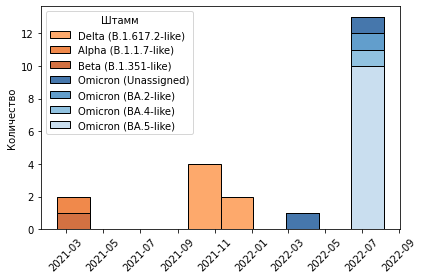

In [13]:
plot_df = meta_df.loc[STRAINS].copy()

plot_df = plot_df.rename(columns={
    "scorpio_call": "Штамм",
    "date": "Дата"
})

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    bottom(np.linspace(0.5, 0.8, 3)),
    top(np.linspace(0.1, 0.7, 4)),
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.histplot(
    x="Дата",
    hue="Штамм",
    multiple="stack",
    data=plot_df,
    bins=10,
    palette=cmap.colors
)
plt.ylabel("Количество")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../../pictures/moscow-strains.png", dpi=500)

In [14]:
meta_df.loc[:, "group"] = "first"
meta_df.loc[meta_df["days"] > 700, "group"] = "second"

In [15]:
# region count df

In [16]:
count_df = None
for protein in PROTEINS:
    if protein != "RNA":
        df = pd.read_csv(f"../../results/russia_mos_LUAD_{protein}/seed.csv", sep=";", index_col=0)
    else:
        df = pd.read_csv(f"../../results/russia_mos_LUAD/seed.csv", sep=";", index_col=0)
    
    df.index = df.index.str.lstrip(">")
    df = df.loc[STRAINS][MIMATS]
    
    df["strain"] = df.index
    df["region"] = [protein] * len(df)
    
    if count_df is None:
        count_df = df
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)

for mimat in MIMATS:
    count_df[mimat] = count_df[mimat].apply(lambda x: region_count(x))

count_df.loc[:, "count"] = 0
count_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    count_df["count"] += count_df[mimat]
    count_df["weighted count"] += count_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 622.36it/s]


In [17]:
wcount_df = pd.read_csv("../../results/wuhan_LUAD/seed.csv", sep=";", index_col=0)

for mimat in MIMATS:
    wcount_df[mimat] = wcount_df[mimat].apply(lambda x: region_count(x))
    
wcount_df.loc[:, "count"] = 0
wcount_df.loc[:, "weighted count"] = 0
for mimat in tqdm.tqdm(MIMATS):
    expression = (miRNA_df.loc[mimat, "CPM"] / TOTAL_EXPRESSION)
    wcount_df["count"] += wcount_df[mimat]
    wcount_df["weighted count"] += wcount_df[mimat] * expression

100%|██████████| 32/32 [00:00<00:00, 725.47it/s]


In [18]:
# average count of binding regions

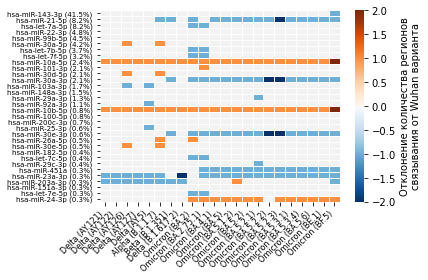

In [19]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

for mimat in MIMATS:
    plot_df[mimat] = plot_df[mimat] - int(wcount_df[mimat])
    
plot_df = plot_df.join(meta_df[["scorpio_call", "lineage"]], how="left")
plot_df["strain"] = plot_df["scorpio_call"].str.split("(").str[0] + "(" + \
    plot_df["lineage"] + ")"
plot_df.index = plot_df["strain"]
plot_df = plot_df[MIMATS]

plot_df = plot_df.transpose()

miRNA_df.index = miRNA_df["MIMAT"]
plot_df = plot_df.join(miRNA_df[["miRNA", "CPM"]], how="left").sort_values(by="CPM", ascending=False)
plot_df.index = plot_df["miRNA"]
plot_df = plot_df.drop(columns=["miRNA", "CPM"])

plot_df["index"] = plot_df.index
miRNA_df.index = miRNA_df["miRNA"]
plot_df["index"] = plot_df["index"].apply(lambda x: f"{x} ({miRNA_df.loc[x]['CPM'] / miRNA_df['CPM'].sum() * 100:.1f}%)")
miRNA_df.index = miRNA_df["MIMAT"]
plot_df.index = plot_df["index"]
plot_df = plot_df.drop(columns=["index"])

bottom = mpl.colormaps['Oranges']
top = mpl.colormaps['Blues_r']
colors = np.vstack((
    top(np.linspace(0, 1, 128)),
    [0.05, 0.05, 0.05, 0.05],
    bottom(np.linspace(0, 1, 128))
))
cmap = ListedColormap(colors, name='OrangeBlue')

sns.heatmap(
    plot_df,
    cmap=cmap,
    linewidths=1,
    linecolor="white",
    cbar_kws={"label": "Отклонение количества регионов\nсвязывания от Wuhan варианта"}
)

plt.yticks(
    [0.5 + i for i in range(len(plot_df))],
    labels=plot_df.index.to_list(),
    fontsize=7
)
plt.ylabel("")

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.savefig("../../pictures/miRNA-covid.png", dpi=500)

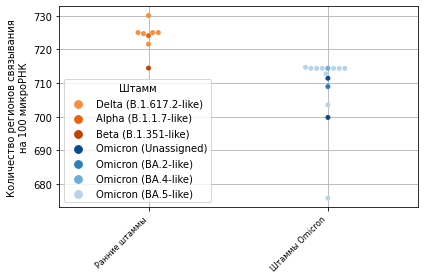

In [61]:
plot_df = count_df.loc[count_df["region"] == "RNA"].copy()
plot_df.index = plot_df["strain"]
plot_df = plot_df[["weighted count"]]

plot_df = plot_df.join(meta_df[["scorpio_call", "lineage", "group"]], how="left")
plot_df.loc[plot_df["group"] == "first", "group"] = "Ранние штаммы"
plot_df.loc[plot_df["group"] == "second", "group"] = "Штаммы Omicron"
plot_df = plot_df.rename(columns={
    "scorpio_call": "Штамм"
})

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    bottom(np.linspace(0.5, 0.8, 3)),
    top(np.linspace(0.1, 0.7, 4)),
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.swarmplot(
    y="weighted count",
    x="group",
    hue="Штамм",
    data=plot_df,
    palette=cmap.colors
)

ax.set_xlabel("")
ax.set_ylabel("Количество регионов связывания\nна 100 микроРНК")

ax.set_yticks(
    [6.8, 6.9, 7.0, 7.1, 7.2, 7.3],
    [680, 690, 700, 710, 720, 730]
)

plt.xticks(
    fontsize=8,
    rotation=45,
    ha="right"
)

plt.grid()
plt.tight_layout()
plt.savefig("../../pictures/covid-weighted.png", dpi=500)

In [21]:
# seed region distribution

In [22]:
seed_df = pd.read_csv("../../results/russia_mos_LUAD/seed.csv", sep=";", index_col=0)
seed_df.index = seed_df.index.str.lstrip(">")
seed_df = seed_df.loc[STRAINS][MIMATS]

seed_df = seed_df.join(meta_df[["lineage", "length", "days", "group"]], how="left")

In [23]:
first_group = seed_df.loc[seed_df["group"] == "first"]
second_group = seed_df.loc[seed_df["group"] == "second"]

In [24]:
def extract(seeds):
    seeds = seeds.lstrip("[").rstrip("]").split(", ")
    seeds = list(map(int, [s for s in seeds if s]))
    return seeds

result_df = pd.DataFrame(columns=["group", "seed"])
for name, group in zip(("first", "second"), (first_group, second_group)):
    coords = []
    for mimat in MIMATS:
        expression = int(miRNA_df.loc[mimat]["CPM"] / TOTAL_EXPRESSION * 100)
        seeds = group[mimat].apply(lambda x: extract(x) * expression).to_list()
        append = []
        for s in seeds:
            append += s
        
        append_df = pd.DataFrame(columns=result_df.columns)
        append_df["seed"] = append
        append_df.loc[:, "group"] = name    
        result_df = pd.concat([result_df, append_df], ignore_index=True)
        
result_df.head()

,group,seed
0,first,9860
1,first,12449
2,first,19060
3,first,9860
4,first,12449


/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


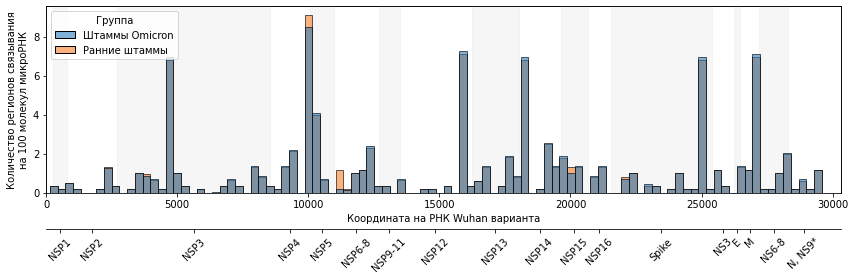

In [25]:
plot_df = result_df.copy()
plot_df.loc[plot_df["group"] == "first", "group"] = "Ранние штаммы"
plot_df.loc[plot_df["group"] == "second", "group"] = "Штаммы Omicron"
plot_df = plot_df.rename(columns={
    "group": "Группа"
})

fig, ax = plt.subplots(figsize=(12, 4))

ax.set_ylabel("Количество регионов связывания\nна 100 молекул микроРНК")
ax.set_xlabel("Координата на РНК Wuhan варианта") 
ax.set_xlim(0, 30330)

annotation = {
    "NSP1": "266-805",
    "NSP2": "806-2719",
    "NSP3": "2720-8554",
    "NSP4": "8555-10054",
    "NSP5": "10055-10972",
    # "NSP6": "10973-11842",
    # "NSP7": "11843-12091",
    # "NSP8": "12092-12685",
    "NSP6-8": "10973-12685",
    # "NSP9": "12686-13024",
    # "NSP10": "13025-13441",
    # "NSP11": "13442-13480",
    "NSP9-11": "12686-13480",
    # "NSP12": "13442-13468",
    "NSP12": "13468-16236",
    "NSP13": "16237-18039",
    "NSP14": "18040-19620",
    "NSP15": "19621-20658",
    "NSP16": "20659-21552",
    "Spike": "21563-25384",
    "NS3": "25393-26220",
    "E": "26245-26472",
    "M": "26523-27191",
    # "NS6": "27202-27387",
    # "NS7a": "27394-27759",
    # "NS7b": "27756-27887",
    # "NS8": "27894-28259",
    "NS6-8": "27202-28295",
    "N, NS9*": "28274-29533",
    # "NS9b": "28284-28577",
    # "NS9c": "28734-28955"
}

axsub = ax.twiny()
axsub.xaxis.set_ticks_position('bottom')
axsub.spines['bottom'].set_position(('outward', 36))

ticks = []
centers = []
proteins = []
for protein, region in annotation.items():
    start, end = map(int, region.split("-"))
    ticks.append(start - 1)
    ticks.append(end - 1)
    
    center = (start + end - 2) // 2
    centers.append(center)
    proteins.append(protein)

i = 0
while i < len(ticks):
    axsub.axvspan(ticks[i], ticks[i + 1], alpha=0.2, color="lightgrey")
    i += 4

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')
    
sns.histplot(
    x="seed",
    hue="Группа",
    hue_order=["Штаммы Omicron", "Ранние штаммы"],
    data=plot_df,
    stat="probability",
    common_norm=False,
    bins=100,
    palette=cmap.colors,
    alpha=0.6,
    ax=axsub
)

axsub.set_xlim(0, 30330)
    
axsub.set_xticks(
    centers,
    labels=proteins,
    rotation=45,
    ha="center"
)

axsub.set_xlabel("")

ax.set_yticks(
    [i / 100 for i in range(0, 9, 2)],
    labels=[i for i in range(0, 9, 2)]
)

plt.tight_layout()
# plt.savefig("../../pictures/seed-distribution-test.png", dpi=500)

In [26]:
# proteins contribution

In [66]:
result_df = pd.DataFrame(columns=[
    "region", "length",
    "first weighted", "second weighted",
    "first count", "second count",
    "p-value"
])

for protein in PROTEINS:
    if protein == "RNA":
        length = 30331
    else:
        length = list(map(int, ANNOTATION[protein].split("-")))
        length = length[1] - length[0] + 1
    
    df = count_df.loc[count_df["region"] == protein]
    df.index = df["strain"]
    df = df.join(meta_df[["group"]], how="left")
    df = df.drop(columns=["strain"]).reset_index()
    
    first_group = df.loc[df["group"] == "first"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    second_group = df.loc[df["group"] == "second"][[
        "strain", "weighted count", "count"
    ]].groupby("strain").sum()
    
    try:
        stat, pv = mannwhitneyu(
            first_group["weighted count"],
            second_group["weighted count"]
        )
    except:
        pv = 1
        
    append_df = pd.DataFrame(
        columns=result_df.columns.to_list(),
        data=[[
            protein,
            length,
            first_group["weighted count"].mean(),
            second_group["weighted count"].mean(),
            first_group["count"].mean(),
            second_group["count"].mean(),
            pv
        ]]
    )
    
    result_df = pd.concat([result_df, append_df], ignore_index=True)

result_df["fdr"] = np.array(result_df["p-value"]) * len(result_df) / rankdata(result_df["p-value"])
result_df.loc[result_df["fdr"] > 1, "fdr"] = 1

In [68]:
result_df["first weighted"] *= 100
result_df["second weighted"] *= 100
result_df.to_csv("russia_mos_protein_contribution.csv", sep=",", index=None)

In [53]:
print_df = result_df.drop(columns=["first count", "second count", "p-value"])
print_df["first weighted"] *= 100
print_df["second weighted"] *= 100
print_df = print_df.loc[print_df["fdr"] < 0.05]
for column in print_df.columns:
    print(f"& {column} ", end="")
print("\\\\")
print("\\hline")

for i, row in print_df.iterrows():
    for column in print_df.columns:
        if column == "fdr":
            print(f"& {float(row[column]):.4f} ", end="")
        elif column not in ["region", "length"]:
            print(f"& {float(row[column]):.2f} ", end="")
        else:
            print(f"& {row[column]} ", end="")
    print("\\\\")
    print("\\hline")

& region & length & first weighted & second weighted & fdr \\
\hline
& NSP2 & 1914 & 18.99 & 18.10 & 0.0006 \\
\hline
& NSP6 & 870 & 17.30 & 11.04 & 0.0019 \\
\hline
& NSP15 & 1038 & 33.53 & 31.06 & 0.0002 \\
\hline
& NS8 & 366 & 13.81 & 14.08 & 0.0006 \\
\hline
& N & 1260 & 18.86 & 19.77 & 0.0005 \\
\hline
& RNA & 30331 & 723.74 & 709.11 & 0.0009 \\
\hline


In [34]:
result_df.loc[result_df["region"] != "RNA"][["first weighted", "second weighted"]].sum()

first weighted     7.372947
second weighted    7.233275
dtype: float64

In [36]:
result_df.loc[result_df["region"] == "RNA"][["first count", "second count"]].sum()

first count     313.875000
second count    311.142857
dtype: float64

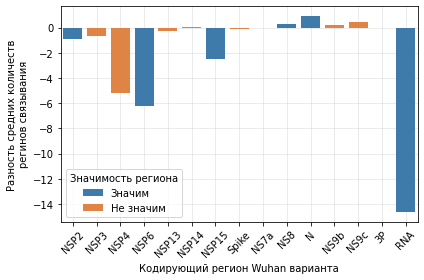

In [65]:
plot_df = result_df.copy()

plot_df["difference"] = (plot_df["second weighted"] - plot_df["first weighted"]) * 100
plot_df["fdr"] = np.array(plot_df["p-value"]) * len(plot_df) / rankdata(plot_df["p-value"])

plot_df["Значимость региона"] = "Не значим"
plot_df.loc[plot_df["fdr"] < 0.05, "Значимость региона"] = "Значим"

top = mpl.colormaps['Blues_r']
bottom = mpl.colormaps['Oranges']
colors = np.vstack((
    top(np.linspace(0.3, 1, 1)),
    bottom(np.linspace(0.55, 1, 1))
))
cmap = ListedColormap(colors, name='OrangeBlue')

ax = sns.barplot(
    x="region",
    y="difference",
    hue="Значимость региона",
    hue_order=["Значим", "Не значим"],
    data=plot_df.loc[np.abs(plot_df["difference"]) > 0.001],
    palette=cmap.colors,
    dodge=False
)

plt.xlabel("Кодирующий регион Wuhan варианта")
plt.ylabel("Разность средних количеств\nрегинов связывания")
ax.set_axisbelow(True)
plt.grid(alpha=0.3)
plt.xticks(
    rotation=45,
    ha="center"
)
plt.tight_layout()
plt.savefig("../../pictures/mRNA-contribution.png", dpi=500)